In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/2357gi/Sandbox/signatej/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


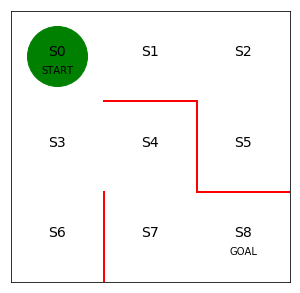

In [4]:
# 初期状態での迷路の様子_

# 図を描く大きさと、図の変数を宣言。
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# make wall
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# make points
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定とメモリを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地に丸を描画する。
line, = ax.plot([0.5], [2.5], 'o', color = 'g', markersize=60)

In [5]:
# 初期の方策を決定するparams theta_0を設定

# 行は0~7, 列は移動方向で上右下左を表す。
theta_0 = np.array([[np.nan, 1, 1, np.nan],  
                   [np.nan, 1, np.nan, 1],
                    [np.nan, np.nan, 1, 1],
                   [1, 1, 1, np.nan],        
                   [np.nan, np.nan, 1, 1],   
                   [1, np.nan, np.nan, np.nan],  
                   [1, np.nan, np.nan, np.nan],  
                   [1, 1, np.nan, np.nan],       
                    ])

# 方策反復法の実装
強化学習の方策反復法を実装する。
ランダムで移動する方策を実装したが、ここからエージェントが一直線にゴールへ移動するために考える。
方策に従って行動しゴールした時に、早くゴールできたケースで実行した行動(action)は重要だと考え、その行動を多く取り入れるようにする方策を更新する作戦。
->**方策反復法**

### 方策を求める方法を変更する
今まではθを割合に変換し、方策としていた。
今回はソフトマックス関数を使用する。
$$
P(θ_i) = {\frac{exp(βθ_i)}{{\sum_(j=1)^(N_a)}exp(βθ_j)}}
$$
ソフトマックス関数は逆温度βが小さいほど行動がよりランダムになるという性質がある。

In [6]:
def softmax_convert_into_pi_from_theta(theta):
    
    beta = 1.0
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    
    exp_theta = np.exp(beta * theta)
    
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
    
    # pi = np.nan_to_sum(pi)
    pi = np.where( np.isnan(pi),0,pi)
    
    return pi

In [7]:
pi_0 = softmax_convert_into_pi_from_theta(theta_0)

In [8]:
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

### 方策に従ってエージェントを移動させる関数
今回はどの行動が有効だったかをフィードバックするために、
どの行動をとったかを示すactionを用意する。

In [9]:
def get_action_and_next_s(pi, s):
    direction = ['up', 'right', 'down', 'left']
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == 'up':
        action = 0
        s_next = s - 3
    elif next_direction == 'right':
        action = 1
        s_next = s + 1
    elif next_direction == 'down':
        action = 2
        s_next = s + 3
    elif next_direction == 'left':
        action = 3
        s_next = s - 1
    
    return [action, s_next]

In [10]:
def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [[0, np.nan]]
    
    while (1):  # ゴールするまでループ
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action  # 現在の状況を入力。一番最後に撮った行動なので[-1]
        
        s_a_history.append([next_s, np.nan])
        
        if next_s == 8:
            break
        else:
            s = next_s
            
    return s_a_history

In [11]:
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print('迷路を解くのにかかったステップ数は' + str(len(s_a_history) - 1) + 'です。')

[[0, 2], [3, 2], [6, 0], [3, 0], [0, 2], [3, 0], [0, 1], [1, 3], [0, 1], [1, 3], [0, 2], [3, 1], [4, 2], [7, 1], [8, nan]]
迷路を解くのにかかったステップ数は14です。


In [12]:
s_a_history[1]

[3, 2]

In [13]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = s_a_history[i][0] # 現在の座標を描く
    x = (state %3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history),
                              interval=200, repeat=True)

HTML(anim.to_jshtml())

# 方策勾配法に従い方策を更新
方策勾配法に従い方策を更新する。
$$
θ_((s_i),(a_j)) = θ_((s_i),(a_j)) + n
$$

In [14]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1  # 学習率
    T = len(s_a_history) - 1
    
    [m, n] = theta.shape
    delta_theta = theta.copy()  # Δthetaの元を作成。numpyはCでできていて、ポインタを実装しているので = だとどうメモリを参照してしまう。
    
    # delta_thetaを要素ごとに求める
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # thetaがnanでない場合
                
                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 履歴からiのものを取り出す内包表記
                
                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 履歴からi, jのものを取り出す内包表記
                
                N_i = len(SA_i) # 状態iで行動した総回数
                N_ij = len(SA_ij) # 状態ijで行動した総回数
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T
    
    net_theta = theta + eta * delta_theta
    
    return net_theta
                
    

In [15]:
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.         0.49821429 0.50178571 0.        ]
 [0.         0.49642863 0.         0.50357137]
 [0.         0.         0.5        0.5       ]
 [0.33492252 0.33253874 0.33253874 0.        ]
 [0.         0.         0.50178571 0.49821429]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.49821429 0.50178571 0.         0.        ]]


## 探索とパラメータの更新を規定値まで繰り返すプログラム

In [16]:
step_epsilon = 10**-4  # 10^-4よりもパラメータの変化の値が小さくなったら更新を終了する。

theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:
    s_a_history = goal_maze_ret_s_a(pi)  # 方策piで迷路内を探索したログを収める。
    new_theta = update_theta(theta, pi, s_a_history)
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
    print(np.sum(np.abs(new_pi - pi)))  # 方策の変化を出力
    print('試行' + str(count) + '回目で、迷路を解くまでにかかったStep数は' + str(len(s_a_history) - 1) + 'です。')
    
    if np.sum(np.sum(np.abs(new_pi - pi))) < step_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi
        count += 1

0.007361562620187945
試行1回目で、迷路を解くまでにかかったStep数は40です。
0.013514404935695778
試行2回目で、迷路を解くまでにかかったStep数は102です。
0.04871349378770534
試行3回目で、迷路を解くまでにかかったStep数は4です。
0.009692219261208002
試行4回目で、迷路を解くまでにかかったStep数は96です。
0.021497982914248814
試行5回目で、迷路を解くまでにかかったStep数は16です。
0.015217733383340426
試行6回目で、迷路を解くまでにかかったStep数は22です。
0.010306103140131806
試行7回目で、迷路を解くまでにかかったStep数は102です。
0.007236506940114129
試行8回目で、迷路を解くまでにかかったStep数は126です。
0.006969618471246386
試行9回目で、迷路を解くまでにかかったStep数は174です。
0.024778207562043242
試行10回目で、迷路を解くまでにかかったStep数は8です。
0.007097371947112241
試行11回目で、迷路を解くまでにかかったStep数は62です。
0.02307120095299836
試行12回目で、迷路を解くまでにかかったStep数は16です。
0.016508515733197116
試行13回目で、迷路を解くまでにかかったStep数は16です。
0.019499936898277836
試行14回目で、迷路を解くまでにかかったStep数は28です。
0.007482365259997015
試行15回目で、迷路を解くまでにかかったStep数は96です。
0.021804498095081948
試行16回目で、迷路を解くまでにかかったStep数は14です。
0.013201637567123226
試行17回目で、迷路を解くまでにかかったStep数は18です。
0.00852302578041253
試行18回目で、迷路を解くまでにかかったStep数は40です。
0.005197289630207047
試行19回目で、迷路を解くまでにかかったStep数は112です。
0.

0.01136035958654108
試行230回目で、迷路を解くまでにかかったStep数は16です。
0.020829749986904705
試行231回目で、迷路を解くまでにかかったStep数は36です。
0.029580744987919322
試行232回目で、迷路を解くまでにかかったStep数は4です。
0.013501880863648508
試行233回目で、迷路を解くまでにかかったStep数は10です。
0.024651184705841267
試行234回目で、迷路を解くまでにかかったStep数は6です。
0.03161653430342348
試行235回目で、迷路を解くまでにかかったStep数は8です。
0.014569595172661043
試行236回目で、迷路を解くまでにかかったStep数は28です。
0.012946088675237222
試行237回目で、迷路を解くまでにかかったStep数は22です。
0.009308968455573108
試行238回目で、迷路を解くまでにかかったStep数は10です。
0.028970526122262363
試行239回目で、迷路を解くまでにかかったStep数は4です。
0.027421129406039357
試行240回目で、迷路を解くまでにかかったStep数は6です。
0.028422996093491387
試行241回目で、迷路を解くまでにかかったStep数は4です。
0.019230166135315807
試行242回目で、迷路を解くまでにかかったStep数は12です。
0.027944289805228395
試行243回目で、迷路を解くまでにかかったStep数は4です。
0.02534523463785973
試行244回目で、迷路を解くまでにかかったStep数は6です。
0.008829554534855621
試行245回目で、迷路を解くまでにかかったStep数は12です。
0.02965324641393638
試行246回目で、迷路を解くまでにかかったStep数は12です。
0.016681515052924784
試行247回目で、迷路を解くまでにかかったStep数は14です。
0.016090280266521317
試行248回目で、迷路を解くまでにかか

0.02218638890504096
試行441回目で、迷路を解くまでにかかったStep数は8です。
0.013158592231211935
試行442回目で、迷路を解くまでにかかったStep数は24です。
0.014827398887260118
試行443回目で、迷路を解くまでにかかったStep数は8です。
0.024385992260649275
試行444回目で、迷路を解くまでにかかったStep数は10です。
0.014988182545235415
試行445回目で、迷路を解くまでにかかったStep数は4です。
0.014783900486448287
試行446回目で、迷路を解くまでにかかったStep数は4です。
0.014583133487673677
試行447回目で、迷路を解くまでにかかったStep数は4です。
0.02054483950065432
試行448回目で、迷路を解くまでにかかったStep数は6です。
0.015059055521869466
試行449回目で、迷路を解くまでにかかったStep数は8です。
0.014393063904924633
試行450回目で、迷路を解くまでにかかったStep数は4です。
0.014199309459709764
試行451回目で、迷路を解くまでにかかったStep数は4です。
0.02024876903649081
試行452回目で、迷路を解くまでにかかったStep数は6です。
0.02012722983915463
試行453回目で、迷路を解くまでにかかったStep数は14です。
0.01121397547056456
試行454回目で、迷路を解くまでにかかったStep数は6です。
0.013978850069335219
試行455回目で、迷路を解くまでにかかったStep数は4です。
0.013792151440111575
試行456回目で、迷路を解くまでにかかったStep数は4です。
0.01672376523181096
試行457回目で、迷路を解くまでにかかったStep数は6です。
0.02331176881905879
試行458回目で、迷路を解くまでにかかったStep数は10です。
0.013642731703601266
試行459回目で、迷路を解くまでにかかったStep数は4

0.006354483491986029
試行693回目で、迷路を解くまでにかかったStep数は4です。
0.006289546734644394
試行694回目で、迷路を解くまでにかかったStep数は4です。
0.00622553202701881
試行695回目で、迷路を解くまでにかかったStep数は4です。
0.006162423184118304
試行696回目で、迷路を解くまでにかかったStep数は4です。
0.006100204347110949
試行697回目で、迷路を解くまでにかかったStep数は4です。
0.012872730503376908
試行698回目で、迷路を解くまでにかかったStep数は16です。
0.006129691779062529
試行699回目で、迷路を解くまでにかかったStep数は4です。
0.014369546881227241
試行700回目で、迷路を解くまでにかかったStep数は6です。
0.012894803989900797
試行701回目で、迷路を解くまでにかかったStep数は8です。
0.006151695516886019
試行702回目で、迷路を解くまでにかかったStep数は4です。
0.009582363469431157
試行703回目で、迷路を解くまでにかかったStep数は6です。
0.006114505601505046
試行704回目で、迷路を解くまでにかかったStep数は4です。
0.006052791938359003
試行705回目で、迷路を解くまでにかかったStep数は4です。
0.005991947565949174
試行706回目で、迷路を解くまでにかかったStep数は4です。
0.014208562030021243
試行707回目で、迷路を解くまでにかかったStep数は6です。
0.010212041157469182
試行708回目で、迷路を解くまでにかかったStep数は8です。
0.01422323583693258
試行709回目で、迷路を解くまでにかかったStep数は6です。
0.014234099529515626
試行710回目で、迷路を解くまでにかかったStep数は8です。
0.015606009921532535
試行711回目で、迷路を解くまでにかかったStep数

試行942回目で、迷路を解くまでにかかったStep数は4です。
0.006778195706975437
試行943回目で、迷路を解くまでにかかったStep数は6です。
0.0033790016431726744
試行944回目で、迷路を解くまでにかかったStep数は4です。
0.0033522380577218763
試行945回目で、迷路を解くまでにかかったStep数は4です。
0.0033257789762397225
試行946回目で、迷路を解くまでにかかったStep数は4です。
0.003299619952428237
試行947回目で、迷路を解くまでにかかったStep数は4です。
0.009670462970170428
試行948回目で、迷路を解くまでにかかったStep数は8です。
0.006991140442710375
試行949回目で、迷路を解くまでにかかったStep数は6です。
0.00673797272782508
試行950回目で、迷路を解くまでにかかったStep数は6です。
0.003370194889718431
試行951回目で、迷路を解くまでにかかったStep数は4です。
0.005835001255825235
試行952回目で、迷路を解くまでにかかったStep数は6です。
0.005909765074812612
試行953回目で、迷路を解くまでにかかったStep数は6です。
0.003374066586355015
試行954回目で、迷路を解くまでにかかったStep数は4です。
0.01309889540149347
試行955回目で、迷路を解くまでにかかったStep数は10です。
0.0033772312818396363
試行956回目で、迷路を解くまでにかかったStep数は4です。
0.003350434333434772
試行957回目で、迷路を解くまでにかかったStep数は4です。
0.01318661334779244
試行958回目で、迷路を解くまでにかかったStep数は10です。
0.011190133129164441
試行959回目で、迷路を解くまでにかかったStep数は6です。
0.01310998638254407
試行960回目で、迷路を解くまでにかかったStep数は10です。
0.009937672

試行1192回目で、迷路を解くまでにかかったStep数は8です。
0.002012173221805476
試行1193回目で、迷路を解くまでにかかったStep数は4です。
0.00636215007332578
試行1194回目で、迷路を解くまでにかかったStep数は12です。
0.0020178220870003677
試行1195回目で、迷路を解くまでにかかったStep数は4です。
0.002004939873920579
試行1196回目で、迷路を解くまでにかかったStep数は4です。
0.001992178367388124
試行1197回目で、迷路を解くまでにかかったStep数は4です。
0.0019795360855100405
試行1198回目で、迷路を解くまでにかかったStep数は4です。
0.0019670115687702647
試行1199回目で、迷路を解くまでにかかったStep数は4です。
0.00195460337963059
試行1200回目で、迷路を解くまでにかかったStep数は4です。
0.001942310102141069
試行1201回目で、迷路を解くまでにかかったStep数は4です。
0.004474957729858543
試行1202回目で、迷路を解くまでにかかったStep数は6です。
0.004395609908527172
試行1203回目で、迷路を解くまでにかかったStep数は6です。
0.001956691774922907
試行1204回目で、迷路を解くまでにかかったStep数は4です。
0.0019444085242220147
試行1205回目で、迷路を解くまでにかかったStep数は4です。
0.0019322382751112907
試行1206回目で、迷路を解くまでにかかったStep数は4です。
0.0019201796675498428
試行1207回目で、迷路を解くまでにかかったStep数は4です。
0.006396213482367713
試行1208回目で、迷路を解くまでにかかったStep数は8です。
0.0019444496153671123
試行1209回目で、迷路を解くまでにかかったStep数は4です。
0.0019322542738111556
試行1210回目で、迷路を解くまでにかかっ

0.0010444820961162914
試行1466回目で、迷路を解くまでにかかったStep数は4です。
0.001039620240707216
試行1467回目で、迷路を解くまでにかかったStep数は4です。
0.0033206748714197064
試行1468回目で、迷路を解くまでにかかったStep数は6です。
0.004988798989049352
試行1469回目で、迷路を解くまでにかかったStep数は8です。
0.001061058116421855
試行1470回目で、迷路を解くまでにかかったStep数は4です。
0.0010560904917908571
試行1471回目で、迷路を解くまでにかかったStep数は4です。
0.0010511570658454615
試行1472回目で、迷路を解くまでにかかったStep数は4です。
0.0038008574318753527
試行1473回目で、迷路を解くまでにかかったStep数は6です。
0.0010594985064813316
試行1474回目で、迷路を解くまでにかかったStep数は4です。
0.00105453003482682
試行1475回目で、迷路を解くまでにかかったStep数は4です。
0.0010495958788396369
試行1476回目で、迷路を解くまでにかかったStep数は4です。
0.0010446957270087986
試行1477回目で、迷路を解くまでにかかったStep数は4です。
0.0010398292713159271
試行1478回目で、迷路を解くまでにかかったStep数は4です。
0.0010349962071885925
試行1479回目で、迷路を解くまでにかかったStep数は4です。
0.001030196233454135
試行1480回目で、迷路を解くまでにかかったStep数は4です。
0.0010254290522935632
試行1481回目で、迷路を解くまでにかかったStep数は4です。
0.0010206943691995658
試行1482回目で、迷路を解くまでにかかったStep数は4です。
0.0010159918929311534
試行1483回目で、迷路を解くまでにかかったStep数は4です。
0.00101132133547

0.0006521490655533486
試行1786回目で、迷路を解くまでにかかったStep数は4です。
0.000649678879675205
試行1787回目で、迷路を解くまでにかかったStep数は4です。
0.0028262948660677037
試行1788回目で、迷路を解くまでにかかったStep数は6です。
0.0006566128096293783
試行1789回目で、迷路を解くまでにかかったStep数は4です。
0.000654114226433862
試行1790回目で、迷路を解くまでにかかったStep数は4です。
0.0006516298247152344
試行1791回目で、迷路を解くまでにかかったStep数は4です。
0.0006491594976600172
試行1792回目で、迷路を解くまでにかかったStep数は4です。
0.0026640018980080213
試行1793回目で、迷路を解くまでにかかったStep数は6です。
0.0006546512085828966
試行1794回目で、迷路を解くまでにかかったStep数は4です。
0.0006521614229608105
試行1795回目で、迷路を解くまでにかかったStep数は4です。
0.0006496857656263788
試行1796回目で、迷路を解くまでにかかったStep数は4です。
0.0026921933384789903
試行1797回目で、迷路を解くまでにかかったStep数は6です。
0.0006554458190018396
試行1798回目で、迷路を解くまでにかかったStep数は4です。
0.0006529485425131598
試行1799回目で、迷路を解くまでにかかったStep数は4です。
0.0027258452143254577
試行1800回目で、迷路を解くまでにかかったStep数は6です。
0.000658993713959697
試行1801回目で、迷路を解くまでにかかったStep数は4です。
0.0006564725746042478
試行1802回目で、迷路を解くまでにかかったStep数は4です。
0.0029169817056449616
試行1803回目で、迷路を解くまでにかかったStep数は6です。
0.00297011600

試行2075回目で、迷路を解くまでにかかったStep数は6です。
0.006030972231053065
試行2076回目で、迷路を解くまでにかかったStep数は6です。
0.0025106574224818164
試行2077回目で、迷路を解くまでにかかったStep数は6です。
0.0005213148037123139
試行2078回目で、迷路を解くまでにかかったStep数は4です。
0.0005195205999565175
試行2079回目で、迷路を解くまでにかかったStep数は4です。
0.0005177356748865963
試行2080回目で、迷路を解くまでにかかったStep数は4です。
0.0005159599644460021
試行2081回目で、迷路を解くまでにかかったStep数は4です。
0.0026966653852556685
試行2082回目で、迷路を解くまでにかかったStep数は6です。
0.0005236453081491586
試行2083回目で、迷路を解くまでにかかったStep数は4です。
0.0005218318890616996
試行2084回目で、迷路を解くまでにかかったStep数は4です。
0.0005200279264871432
試行2085回目で、迷路を解くまでにかかったStep数は4です。
0.0005182333544820131
試行2086回目で、迷路を解くまでにかかったStep数は4です。
0.0005164481076782232
試行2087回目で、迷路を解くまでにかかったStep数は4です。
0.0005146721212782902
試行2088回目で、迷路を解くまでにかかったStep数は4です。
0.00051290533104726
試行2089回目で、迷路を解くまでにかかったStep数は4です。
0.0005111476733064314
試行2090回目で、迷路を解くまでにかかったStep数は4です。
0.0005093990849320863
試行2091回目で、迷路を解くまでにかかったStep数は4です。
0.000507659503342757
試行2092回目で、迷路を解くまでにかかったStep数は4です。
0.0005059288665005442
試行2093回目で、迷路を解

0.0003901771081838805
試行2386回目で、迷路を解くまでにかかったStep数は4です。
0.0003890335449413633
試行2387回目で、迷路を解くまでにかかったStep数は4です。
0.0003878949729049404
試行2388回目で、迷路を解くまでにかかったStep数は4です。
0.0003867613632001117
試行2389回目で、迷路を解くまでにかかったStep数は4です。
0.0003856326871592153
試行2390回目で、迷路を解くまでにかかったStep数は4です。
0.00038450891632015385
試行2391回目で、迷路を解くまでにかかったStep数は4です。
0.005572634380882027
試行2392回目で、迷路を解くまでにかかったStep数は8です。
0.002203922467554069
試行2393回目で、迷路を解くまでにかかったStep数は6です。
0.0003977313768221309
試行2394回目で、迷路を解くまでにかかったStep数は4です。
0.00039655109103610767
試行2395回目で、迷路を解くまでにかかったStep数は4です。
0.0003953760289173089
試行2396回目で、迷路を解くまでにかかったStep数は4です。
0.0003942061597823482
試行2397回目で、迷路を解くまでにかかったStep数は4です。
0.0003930414531780231
試行2398回目で、迷路を解くまでにかかったStep数は4です。
0.00039188187886871756
試行2399回目で、迷路を解くまでにかかったStep数は4です。
0.00039072740684325744
試行2400回目で、迷路を解くまでにかかったStep数は4です。
0.00038957800730526904
試行2401回目で、迷路を解くまでにかかったStep数は4です。
0.00038843365067751934
試行2402回目で、迷路を解くまでにかかったStep数は4です。
0.000387294307595782
試行2403回目で、迷路を解くまでにかかったStep数は4です。
0.00038

0.0003055405419317078
試行2691回目で、迷路を解くまでにかかったStep数は4です。
0.00030473111398842886
試行2692回目で、迷路を解くまでにかかったStep数は4です。
0.0003039249147298029
試行2693回目で、迷路を解くまでにかかったStep数は4です。
0.0003031219269263759
試行2694回目で、迷路を解くまでにかかったStep数は4です。
0.00030232213346393505
試行2695回目で、迷路を解くまでにかかったStep数は4です。
0.00030152551734100724
試行2696回目で、迷路を解くまでにかかったStep数は4です。
0.00030073206166959104
試行2697回目で、迷路を解くまでにかかったStep数は4です。
0.0002999417496757431
試行2698回目で、迷路を解くまでにかかったStep数は4です。
0.00029915456469605667
試行2699回目で、迷路を解くまでにかかったStep数は4です。
0.0002983704901768913
試行2700回目で、迷路を解くまでにかかったStep数は4です。
0.0002975895096766004
試行2701回目で、迷路を解くまでにかかったStep数は4です。
0.00029681160686044136
試行2702回目で、迷路を解くまでにかかったStep数は4です。
0.0002960367655018767
試行2703回目で、迷路を解くまでにかかったStep数は4です。
0.00029526496948387507
試行2704回目で、迷路を解くまでにかかったStep数は4です。
0.0002944962027915353
試行2705回目で、迷路を解くまでにかかったStep数は4です。
0.0018680450604206325
試行2706回目で、迷路を解くまでにかかったStep数は6です。
0.0002977614322666952
試行2707回目で、迷路を解くまでにかかったStep数は4です。
0.0002969828153846568
試行2708回目で、迷路を解くまでにかかったStep数は4です。
0.0

0.00022768824380717256
試行2993回目で、迷路を解くまでにかかったStep数は4です。
0.0016431392196745512
試行2994回目で、迷路を解くまでにかかったStep数は6です。
0.00023060035022565498
試行2995回目で、迷路を解くまでにかかったStep数は4です。
0.00023007098638116313
試行2996回目で、迷路を解くまでにかかったStep数は4です。
0.00022954344953025202
試行2997回目で、迷路を解くまでにかかったStep数は4です。
0.00022901773124583275
試行2998回目で、迷路を解くまでにかかったStep数は4です。
0.00022849382314859418
試行2999回目で、迷路を解くまでにかかったStep数は4です。
0.00022797171690791193
試行3000回目で、迷路を解くまでにかかったStep数は4です。
0.00022745140424119611
試行3001回目で、迷路を解くまでにかかったStep数は4です。
0.00022693287691205252
試行3002回目で、迷路を解くまでにかかったStep数は4です。
0.00022641612673462638
試行3003回目で、迷路を解くまでにかかったStep数は4です。
0.00022590114556623325
試行3004回目で、迷路を解くまでにかかったStep数は4です。
0.0017470907922023417
試行3005回目で、迷路を解くまでにかかったStep数は6です。
0.00022917450884507237
試行3006回目で、迷路を解くまでにかかったStep数は4です。
0.002495760625075283
試行3007回目で、迷路を解くまでにかかったStep数は8です。
0.00023451060729270945
試行3008回目で、迷路を解くまでにかかったStep数は4です。
0.00023396509064982016
試行3009回目で、迷路を解くまでにかかったStep数は4です。
0.00023342148621280714
試行3010回目で、迷路を解くまでにかかったStep数は4

0.0001765682360222627
試行3316回目で、迷路を解くまでにかかったStep数は4です。
0.010330942125415226
試行3317回目で、迷路を解くまでにかかったStep数は8です。
0.000177346563550446
試行3318回目で、迷路を解くまでにかかったStep数は4です。
0.00017698441545478845
試行3319回目で、迷路を解くまでにかかったStep数は4です。
0.0001766233865628363
試行3320回目で、迷路を解くまでにかかったStep数は4です。
0.00017626347222837215
試行3321回目で、迷路を解くまでにかかったStep数は4です。
0.0001759046678294126
試行3322回目で、迷路を解くまでにかかったStep数は4です。
0.0001755469687676689
試行3323回目で、迷路を解くまでにかかったStep数は4です。
0.00017519037047052967
試行3324回目で、迷路を解くまでにかかったStep数は4です。
0.0001748348683862904
試行3325回目で、迷路を解くまでにかかったStep数は4です。
0.00017448045798991625
試行3326回目で、迷路を解くまでにかかったStep数は4です。
0.0001741271347778621
試行3327回目で、迷路を解くまでにかかったStep数は4です。
0.00017377489426941527
試行3328回目で、迷路を解くまでにかかったStep数は4です。
0.00017342373201074783
試行3329回目で、迷路を解くまでにかかったStep数は4です。
0.00017307364356601226
試行3330回目で、迷路を解くまでにかかったStep数は4です。
0.00017272462452567854
試行3331回目で、迷路を解くまでにかかったStep数は4です。
0.0001723766705021973
試行3332回目で、迷路を解くまでにかかったStep数は4です。
0.004545232872233922
試行3333回目で、迷路を解くまでにかかったStep数は8です。
0.000

0.00015874721925757292
試行3576回目で、迷路を解くまでにかかったStep数は4です。
0.00015843829865803613
試行3577回目で、迷路を解くまでにかかったStep数は4です。
0.0001581302917908825
試行3578回目で、迷路を解くまでにかかったStep数は4です。
0.00015782319501299671
試行3579回目で、迷路を解くまでにかかったStep数は4です。
0.00015751700469826026
試行3580回目で、迷路を解くまでにかかったStep数は4です。
0.00015721171723892362
試行3581回目で、迷路を解くまでにかかったStep数は4です。
0.0001569073290447181
試行3582回目で、迷路を解くまでにかかったStep数は4です。
0.00015660383654502938
試行3583回目で、迷路を解くまでにかかったStep数は4です。
0.00015630123618508296
試行3584回目で、迷路を解くまでにかかったStep数は4です。
0.00015599952442938401
試行3585回目で、迷路を解くまでにかかったStep数は4です。
0.00015569869775964099
試行3586回目で、迷路を解くまでにかかったStep数は4です。
0.00015539875267556527
試行3587回目で、迷路を解くまでにかかったStep数は4です。
0.00015509968569225353
試行3588回目で、迷路を解くまでにかかったStep数は4です。
0.00015480149334599208
試行3589回目で、迷路を解くまでにかかったStep数は4です。
0.00015450417218716012
試行3590回目で、迷路を解くまでにかかったStep数は4です。
0.00015420771878305733
試行3591回目で、迷路を解くまでにかかったStep数は4です。
0.0001539121297212294
試行3592回目で、迷路を解くまでにかかったStep数は4です。
0.008987604368325509
試行3593回目で、迷路を解くまでにかかったStep数は10

試行3871回目で、迷路を解くまでにかかったStep数は4です。
0.00012642338278755737
試行3872回目で、迷路を解くまでにかかったStep数は4です。
0.00012620433155471553
試行3873回目で、迷路を解くまでにかかったStep数は4です。
0.0001259858558477732
試行3874回目で、迷路を解くまでにかかったStep数は4です。
0.00012576795363447753
試行3875回目で、迷路を解くまでにかかったStep数は4です。
0.00012555062288908785
試行3876回目で、迷路を解くまでにかかったStep数は4です。
0.0001253338615951876
試行3877回目で、迷路を解くまでにかかったStep数は4です。
0.0010176041910853074
試行3878回目で、迷路を解くまでにかかったStep数は6です。
0.00012620825544490226
試行3879回目で、迷路を解くまでにかかったStep数は4です。
0.00012599047026146983
試行3880回目で、迷路を解くまでにかかったStep数は4です。
0.00012577325407015817
試行3881回目で、迷路を解くまでにかかったStep数は4です。
0.0001255566048751211
試行3882回目で、迷路を解くまでにかかったStep数は4です。
0.00012534052068613466
試行3883回目で、迷路を解くまでにかかったStep数は4です。
0.00012512499952338843
試行3884回目で、迷路を解くまでにかかったStep数は4です。
0.00012491003941599715
試行3885回目で、迷路を解くまでにかかったStep数は4です。
0.00012469563840091132
試行3886回目で、迷路を解くまでにかかったStep数は4です。
0.00012448179452433442
試行3887回目で、迷路を解くまでにかかったStep数は4です。
0.00012426850584086775
試行3888回目で、迷路を解くまでにかかったStep数は4です。
0.00012405577041345

In [17]:
# 最終的な方策を表示
np.set_printoptions(precision=3, suppress=True)
print(pi)

[[0.    0.012 0.988 0.   ]
 [0.    0.275 0.    0.725]
 [0.    0.    0.406 0.594]
 [0.012 0.977 0.011 0.   ]
 [0.    0.    0.987 0.013]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.017 0.983 0.    0.   ]]


In [18]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = s_a_history[i][0] # 現在の座標を描く
    x = (state %3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history),
                              interval=200, repeat=False)

HTML(anim.to_jshtml())